<a href="https://colab.research.google.com/github/hiebschi/MoSE_scripts/blob/main/loop_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Implementing a Segmentation Model

## 1. Preparations
### 1.1 Install required packages

In [21]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np

### 1.2 Install segmentation model

In [2]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.8 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=dacee58413339f5aac79d6c1fb870396d211d0fd7b02b12f273cf5ea4ecee884
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=e154a176a3e3be6aaa049c5f176896def398ac36689edaab67eac73b8146802b
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch

In [3]:
import segmentation_models_pytorch as smp

### 1.3 Device agnostic code

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1.4 Upload data to colab

In [5]:
# manual upload (for small files)
# from google.colab import files
# uploaded = files.upload()

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [60]:
# Data directories on GOOGLE DRIVE  # -------------------->> ADJUSTABLE
# npy preprocessed patches
preprocessed_patches_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/preprocessed_patches'
# JSON class codes
codes_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/classes'
# Shapefile class labels
labels_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/shapefiles'
# npy Masks
masks_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/masks'

In [25]:
# Class labels
# specific Shapefile path
shp_path = os.path.join(labels_dir, "GSK_24_WGS84_adjusted.shp") # -------------------->> ADJUSTABLE

labels = gpd.read_file(shp_path) # read shapefile
labels_filtered = labels[labels["Elementtyp"].notnull()] # remove NULL
print(labels_filtered["Elementtyp"].unique()) # print all label classes

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


In [14]:
# Class codes
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9}


9

In [15]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[4]

'Totholz'

In [22]:
# Preprocessed patches






In [ ]:
# create list with preprocessed patches
pre_patches_list = [f for f in os.listdir(preprocessed_patches_dir) if f.endswith('.npy')]  # list of all preprocessed patches
pre_patches_list.sort() # sort list alphabetically
# patches_list

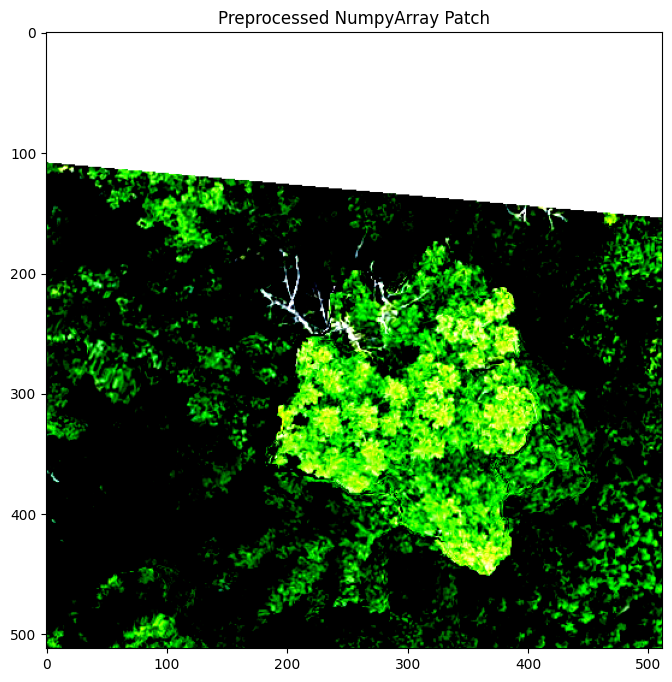

In [17]:
# Test preprocessed patch

#####################
SECTION = "A06" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 4 # -------------------->> ADJUSTABLE
#####################

test_pre_patch_path = preprocessed_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy"

# load NumpyArray (NO DICTIONARY ANYMORE)
test_pre_patch = np.load(test_pre_patch_path)

# plot the preprocessed image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_pre_patch.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("Preprocessed NumpyArray Patch")
plt.show()

In [61]:
# Load masks

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
masks_list.sort() # sort list alphabetically
masks_list

['A01_patch_0_mask.npy',
 'A01_patch_103_mask.npy',
 'A01_patch_104_mask.npy',
 'A01_patch_105_mask.npy',
 'A01_patch_109_mask.npy',
 'A01_patch_110_mask.npy',
 'A01_patch_117_mask.npy',
 'A01_patch_118_mask.npy',
 'A01_patch_123_mask.npy',
 'A01_patch_124_mask.npy',
 'A01_patch_125_mask.npy',
 'A01_patch_130_mask.npy',
 'A01_patch_131_mask.npy',
 'A01_patch_132_mask.npy',
 'A01_patch_133_mask.npy',
 'A01_patch_134_mask.npy',
 'A01_patch_135_mask.npy',
 'A01_patch_137_mask.npy',
 'A01_patch_138_mask.npy',
 'A01_patch_139_mask.npy',
 'A01_patch_144_mask.npy',
 'A01_patch_145_mask.npy',
 'A01_patch_146_mask.npy',
 'A01_patch_14_mask.npy',
 'A01_patch_152_mask.npy',
 'A01_patch_153_mask.npy',
 'A01_patch_154_mask.npy',
 'A01_patch_158_mask.npy',
 'A01_patch_159_mask.npy',
 'A01_patch_15_mask.npy',
 'A01_patch_160_mask.npy',
 'A01_patch_161_mask.npy',
 'A01_patch_162_mask.npy',
 'A01_patch_16_mask.npy',
 'A01_patch_170_mask.npy',
 'A01_patch_171_mask.npy',
 'A01_patch_180_mask.npy',
 'A01_

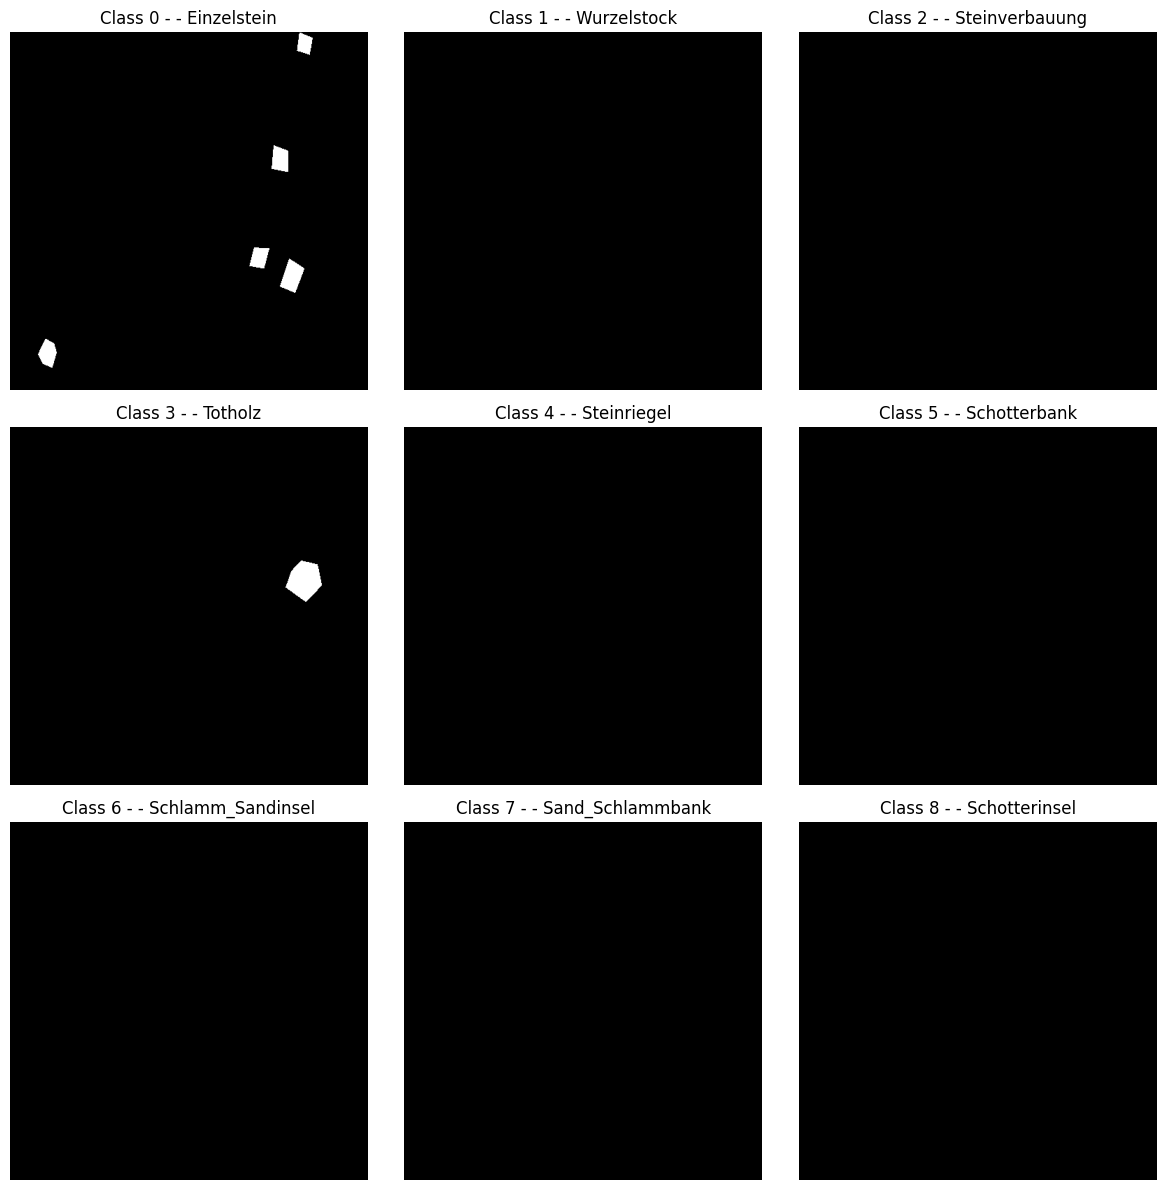

In [62]:
# Test mask

#####################
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 96 # -------------------->> ADJUSTABLE
#####################

test_mask_path = masks_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# load mask
test_mask = np.load(test_mask_path)

# Plot:
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the 9 classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_label_codes[i + 1]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

## 2. Choose segmentation model

In [17]:
model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


## 3. Splitting data into training and test sets

In [36]:
from sklearn.model_selection import train_test_split

In [19]:
# pre_patches_list
# masks_list

In [63]:
# helper-function in order to extract section and patch_id
def extract_section_and_id(file_name):
    parts = file_name.split("_") # split condition: _
    section = parts[0]  # extract section from file_name, e.g. "A01"
    patch_id = parts[2].replace(".npy", "").replace("_mask", "") #  extract patch_id, e.g. 481
    return section, patch_id

In [64]:
# print section and patch_id from masks and patches
print(extract_section_and_id(masks_list[1]))
print(extract_section_and_id(pre_patches_list[175]))

('A01', '103')
('A06', '342')


In [65]:
# group patches by section
section_patches = {} # empty dictionary
for patch in pre_patches_list: # iterate over all preprocessed patches
    section, patch_id = extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch, patch_id)) # creates keys of sections with patches and their ids inside

In [66]:
print(section_patches.keys())
print(section_patches)

dict_keys(['A06', 'A07', 'A08'])
{'A06': [('A06_patch_2296.npy', '2296'), ('A06_patch_2349.npy', '2349'), ('A06_patch_2353.npy', '2353'), ('A06_patch_2354.npy', '2354'), ('A06_patch_2388.npy', '2388'), ('A06_patch_2389.npy', '2389'), ('A06_patch_2391.npy', '2391'), ('A06_patch_2398.npy', '2398'), ('A06_patch_2400.npy', '2400'), ('A06_patch_2408.npy', '2408'), ('A06_patch_2412.npy', '2412'), ('A06_patch_2415.npy', '2415'), ('A06_patch_2416.npy', '2416'), ('A06_patch_2417.npy', '2417'), ('A06_patch_2418.npy', '2418'), ('A06_patch_242.npy', '242'), ('A06_patch_2420.npy', '2420'), ('A06_patch_2421.npy', '2421'), ('A06_patch_2422.npy', '2422'), ('A06_patch_2423.npy', '2423'), ('A06_patch_2424.npy', '2424'), ('A06_patch_2426.npy', '2426'), ('A06_patch_2427.npy', '2427'), ('A06_patch_2428.npy', '2428'), ('A06_patch_2429.npy', '2429'), ('A06_patch_243.npy', '243'), ('A06_patch_2430.npy', '2430'), ('A06_patch_2431.npy', '2431'), ('A06_patch_2432.npy', '2432'), ('A06_patch_2433.npy', '2433'), ('

In [67]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################
### HYPERPARAMETER ####
TRAIN_SECTIONS = ["A01", "A02", "A03", "A04", "A05", "A08"]  # Train sections
TEST_SECTIONS = ["A06", "A07"]  # Validation/Test sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in TRAIN_SECTIONS: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in TEST_SECTIONS:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")

Training Patches: 177
Test Patches: 1477


In [83]:
train_data[8][0]

'A08_patch_105.npy'

In [80]:
def has_mask(patch_name, masks_dir):
    mask_path = os.path.join(masks_dir, patch_name.replace(".npy", "_mask.npy"))
    return os.path.exists(mask_path)

In [81]:
train_with_masks = [f for f in train_data if has_mask(f[0], masks_dir)]
train_background = [f for f in train_data if not has_mask(f[0],masks_dir)]
test_with_masks = [f for f in test_data if has_mask(f[0], masks_dir)]
test_background = [f for f in test_data if not has_mask(f[0], masks_dir)]

print(f"Training mit Masken: {len(train_with_masks)}")
print(f"Training Hintergrund: {len(train_background)}")
print(f"Test mit Masken: {len(test_with_masks)}")
print(f"Test Hintergrund: {len(test_background)}")

Training mit Masken: 70
Training Hintergrund: 107
Test mit Masken: 374
Test Hintergrund: 1103


### ?.1 Choose optimizer and loss function

In [13]:
loss = smp.losses.DiceLoss(mode="multiclass")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Citing

In [41]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }